# Projeto de Férias - Aprendizado de Máquina

## Predição de emissão de CO2 em um dataset sobre turbinas à gás

**Aluno:** Enzo J. Xavier - RM 24035

**Orientador:** Dr. Daniel Roberto Cassar

### Introdução

Contextualizar: Falar do aquecimento global, consequências e focar nos gases do efeito estufa

Relacionar: Falar importância de prever emissão, associada a equipamentos como as turbinas, aprendizado de máquina

Referenciar: Mencionar dataset, características e artigos similares, modelos usados

Aplicar: Explicar MLP, vantagens, séries temporais e outros modelos - comparar eficiência

Codar: Explicar passo a passo, técnicas usadas

Atualmente, as consequências da crise climática são inegáveis para o ecossistema global: Enchentes, eventos climáticos extremos como tornados e o aquecimento global, causado por uma elevação dos gases de efeito estufa (GEE's), responsáveis por controlar a temperatura da atmosfera. Nesse contexto, é essencial buscar soluções para a problemática, em especial analisar a emissão dos GEE's vinda de equipamentos humanos, como indústrias, automóveis e turbinas, visando otimizar esses aparelhos para reduzir essa emissão. Assim, ferramentas como o **Aprendizado de Máquina**, também chamadas de Machine Learning, podem ajudar nesse quesito, por preverem a emissão dos gases a partir de dados pré-existentes. O Aprendizado de Máquina refere-se a ao uso de algoritmos para induzir um modelo preditivo, recebendo como input um ou mais **atributos** (chamados de *features*) e retornando como output cum ou mais **alvos** (conhecidos como *targets*) [1].

Um dos ramos do Machine Learning pode ser trabalhar com **Dados Sequenciais**, cuja ordem importa para o treinamento dos modelos. A exemplo desse ramo existem as **Séries Temporais**, sendo um conjunto de observações ordenadas no tempo, em que é possível identificar padrões como *tendência*, *sazonalidade* e observações discrepantes (ou *outliers*), além de usar a variação passada de uma série para predizer valores futuros aproximados [2].

O objetivo deste notebook é analisar um dataset sobre turbinas [3], fazendo o pré-processamento dos dados, visualizando gráficos informativos, compreendendo a série temporal envolvida e organizando o ambiente para os posteriores treinamentos dos modelos.

#### Importações e definições

Importando as principais bibliotecas usadas neste notebok. A documentação de cada biblioteca se encontra no final do arquivo, na sessão "Referências" [4-10]

In [31]:
import os
import numpy as np
import math
from sklearn.preprocessing import StandardScaler

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import torch
import darts
import skorch

# Ajuste de gráficos
sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (10,7)

Carregando os datasets, que se encontram em uma pasta específica, e criando uma variável intuitiva para cada ano, facilitando a visualização. Para mudar de diretório foram usados métodos da biblioteca $os$

In [3]:
# Diretório atual
atual = os.getcwd()

# Diretório pai
caminho = os.path.dirname(atual)

# Vai pro diretório com os datasets
os.chdir(f'{caminho}\\Datasets')

In [4]:
df_2011 = pd.read_csv('gt_2011.csv', parse_dates = True)
df_2012 = pd.read_csv('gt_2012.csv', parse_dates = True)
df_2013 = pd.read_csv('gt_2013.csv', parse_dates = True)
df_2014 = pd.read_csv('gt_2014.csv', parse_dates = True)
df_2015 = pd.read_csv('gt_2015.csv', parse_dates = True)

O dataset estudado contém 36733 instâncias de 11 propriedades medidas por sensor, agregadas a cada hora (por meio da média ou da soma), de uma turbina a gás localizada na Turquia. Os dados estão ordenados cronologicamente e suas propriedades estão divididas em variáveis ambientais e parâmetros de operação da turbina, com o objetivo de analisar a emissão de gases de combustão, a citar o Monóxido de Carbono (CO) e Óxidos de Nitrogênio (NOx). Cada arquivo contém as medições para um ano em específico, com intervalo entre 2011 e 2015.

Abaixo há uma tabela com mais informações sobre os dados:

| Variável (Abrev.) | Unidade | Mínimo | Máximo | Média | Explicação |  
| --- | --- | --- | --- | --- | --- | 
| Temperatura Amb. (AT) | °C | -6.23 | 37.10 | 17.71 | Temperatura do ar ambiente. |  
| Pressão Amb. (AP) | mbar | 985.85 | 1036.56 | 1013.07 | Pressão do ar ambiente em milibars. |  
| Umidade Amb. (AH) | % | 24.08 | 100.20 | 77.87 | Umidade relativa do ar ambiente. |  
| Pressão Diferencial do Filtro de Ar (AFDP) | mbar | 02.09 | 7.61 | 3.93 | Diferença de pressão através do filtro de ar na entrada da turbina. |  
| Pressão de Exaustão da Turbina a Gás (GTEP) | mbar | 17.70 | 40.72 | 25.56 | Pressão dos gases de exaustão da turbina a gás. | 
| Temperatura de Entrada da Turbina (TIT) | °C | 1000.85 | 1100.89 | 1081.43 | Temperatura dos gases na entrada da turbina. |  
| Temperatura Após a Turbina (TAT) | °C | 511.04 | 550.61 | 546.16 | Temperatura dos gases após a passagem pela turbina. |  
| Pressão de Descarga do Compressor (CDP) | mbar | 9.85 | 15.16 | 12.06 | Pressão do ar após a compressão no compressor. |  
| Rendimento Energético da Turbina (TEY) | MWh | 100.02 | 179.50 | 133.51 | Energia elétrica gerada pela turbina, medida em Megawatts-hora. |  
| Monóxido de Carbono (CO) | mg/m³ | 0.00 | 44.10 | 2.37 | Concentração de monóxido de carbono nos gases de exaustão, em miligramas por metro cúbico. |  
| Óxidos de Nitrogênio (NOx) | mg/m³ | 25.90 | 119.91 | 65.29 | Concentração de óxidos de nitrogênio nos gases de exaustão. |  

Analisar e fazer index corretamente

Analisar e comparar diferenças de horas, ver horário de funcionamento e possíveis erros

In [5]:
linhas_2011 = len(df_2011)
linhas_2012 = len(df_2012)
linhas_2013 = len(df_2013)
linhas_2014 = len(df_2014)
linhas_2015 = len(df_2015)
linhas_total = linhas_2011 + linhas_2012 + linhas_2013 + linhas_2014 + linhas_2015

print(f"Número de linhas em gt_2011.csv: {linhas_2011}")
print(f"Número de linhas em gt_2012.csv: {linhas_2012}")
print(f"Número de linhas em gt_2013.csv: {linhas_2013}")
print(f"Número de linhas em gt_2014.csv: {linhas_2014}")
print(f"Número de linhas em gt_2015.csv: {linhas_2015}")
print(f"Total de linhas: {linhas_total}")

Número de linhas em gt_2011.csv: 7411
Número de linhas em gt_2012.csv: 7628
Número de linhas em gt_2013.csv: 7152
Número de linhas em gt_2014.csv: 7158
Número de linhas em gt_2015.csv: 7384
Total de linhas: 36733


A seguir serão carregados os datasets, processando os dados e visualizando a série temporal para cada ano:

#### Dataset 1: 2011

A tabela abaixo mostra os atributos da turbina com dados de 2011, bem como os alvos a serem preditos i.e, CO e NOX

In [24]:
df_2011

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028
...,...,...,...,...,...,...,...,...,...,...,...
7406,9.0301,1005.6,98.460,3.5421,19.164,1049.7,546.21,111.61,10.400,4.51860,79.559
7407,7.8879,1005.9,99.093,3.5059,19.414,1046.3,543.22,111.78,10.433,4.84700,79.917
7408,7.2647,1006.3,99.496,3.4770,19.530,1037.7,537.32,110.19,10.483,7.96320,90.912
7409,7.0060,1006.8,99.008,3.4486,19.377,1043.2,541.24,110.74,10.533,6.24940,93.227


É possível extrair alguns dados do dataset pelo método *describe()*, com o parâmetro **include = 'all'** incluindo informações como a média de cada coluna, o valor máximo, desvio padrão, entre outras.

In [7]:
df_2011.describe(include= 'all')

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,7411.000000,7411.000000,7411.000000,7411.000000,7411.000000,7411.000000,7411.000000,7411.000000,7411.000000,7411.000000,7411.000000
mean,17.112261,1014.167883,79.174989,4.090755,25.663721,1084.733909,544.503170,135.745675,12.207578,1.572486,67.575392
std,7.428307,6.293003,13.465898,0.661865,4.325835,16.134972,8.288471,16.209187,1.146561,1.845442,10.683331
min,2.116300,995.790000,34.493000,2.758400,17.878000,1000.800000,512.450000,100.170000,9.904400,0.000388,27.765000
25%,10.992000,1009.800000,70.428500,3.644750,23.364500,1082.500000,538.560000,130.745000,11.684000,0.726405,60.361500
50%,16.366000,1013.600000,82.129000,4.026300,24.770000,1088.000000,549.860000,133.810000,12.008000,1.155700,65.542000
75%,23.344500,1018.100000,89.778000,4.480350,29.879500,1099.800000,550.040000,148.325000,13.257000,1.754600,74.314500
max,34.532000,1034.200000,100.170000,7.318900,36.003000,1100.600000,550.610000,170.000000,14.851000,43.622000,119.320000


Percebe-se que a média e o desvio padrão de cada atributo varia significantemente, além de todos terem o mesmo número de contagens, o que é esperado

Nos problemas de aprendizado de máquina, é recomendado fazer um pré-processamento dos dados, garantindo uma melhor performance dos modelos. Nesse caso, será aplicada uma normalização padrão (Standard Scaler, em inglês), a qual deixa a média nula e o desvio padrão unitário. Essa técnica favorece modelos como o MLP por melhorar o tempo de convergência durante a aprendizagem [11]. A fórmula está apresentada abaixo:

$$z_i = \frac{x_i - \mu}{\sigma}$$

onde $\mu$ é a média dos dados, $\sigma$ é o desvio padrão dos dados, $x_i$ é o $i$'nésimo exemplo do conjunto de dados $x$ e $z_i$ é o valor normalizado do exemplo $i$ do conjunto de dados $x$. Logo aplicando aos atributos do problema:

In [8]:
ATRIBUTOS = ['AT','AP','AH','AFDP','GTEP','TIT','TAT','TEY','CDP']
TARGET = ['CO', 'NOX']

X_2011 = df_2011.reindex(ATRIBUTOS, axis=1).values
y_2011 = df_2011.reindex(TARGET, axis=1).values.ravel()

modelo = StandardScaler()
X_2011_norm = modelo.fit_transform(X_2011)

print('Dados originais:', X_2011)
print()
print('Dados normalizados', X_2011_norm)

Dados originais: [[   4.5878 1018.7      83.675  ...  549.83    134.67     11.898 ]
 [   4.2932 1018.3      84.235  ...  550.05    134.67     11.892 ]
 [   3.9045 1018.4      84.858  ...  550.19    135.1      12.042 ]
 ...
 [   7.2647 1006.3      99.496  ...  537.32    110.19     10.483 ]
 [   7.006  1006.8      99.008  ...  541.24    110.74     10.533 ]
 [   6.9279 1007.2      97.533  ...  545.85    111.58     10.583 ]]

Dados normalizados [[-1.68615901  0.7202321   0.33420086 ...  0.64272286 -0.06636656
  -0.27002383]
 [-1.72582079  0.65666515  0.37579019 ...  0.66926755 -0.06636656
  -0.27525722]
 [-1.77815118  0.67255689  0.42205833 ...  0.68615962 -0.0398366
  -0.14442236]
 ...
 [-1.32576993 -1.25034319  1.50917391 ... -0.8667044  -1.57672311
  -1.50423274]
 [-1.36059852 -1.17088451  1.47293177 ... -0.39372639 -1.54278945
  -1.46062112]
 [-1.37111307 -1.10731756  1.36338842 ...  0.1625054  -1.49096349
  -1.4170095 ]]


Perceba que os dados se concentram entre -2.0 e 1.0, com os valores originais menores se tornando mais negativos

##### Gráficos

A biblioteca Plotly será utilizada para a plotagem dos gráficos, uma vez que permite a criação de gráficos interativos, melhorando a visualização dos dados

Plotando um histograma da quantidade de CO e NOX presente no dataset, que indica a distribuição de cada característica:

In [9]:
co_2011 = px.histogram(df_2011, x='CO', title='Histograma do CO - Concentração em mg/m3', range_x=(0,10))
co_2011.add_vline(x=df_2011['CO'].mean(), line_dash="dash", line_color="green", annotation_text="Média", annotation_position="top right")
co_2011.show()

Perceba que a distribuição dessa variável está concentrada em valores pequenos, com concentração média de CO em torno de $2 mg/m³$. Fazendo para o NOX:

In [10]:
nox_2011 = px.histogram(df_2011, x='NOX', title='Histograma do NOX - Concentração em mg/m3', range_x=(40,100))
nox_2011.add_vline(x=df_2011['NOX'].mean(), line_dash="dash", line_color="green", annotation_text="Média", annotation_position="top right")
nox_2011.show()

Já para o gás derivado de nitrogênio, a distribuição é mais central, com uma concentração média de quase $70 mg/m³$

##### Série Temporal

Para cada atributo do problema, existe um gráfico correspondente demonstrando sua variação no tempo. Abaixo, plotou-se a coluna *AT*, contendo a temperatura ambiente das turbinas

<Axes: title={'center': 'Variação da temperatura ambiente em 2011'}, xlabel='Hora', ylabel='Valor'>

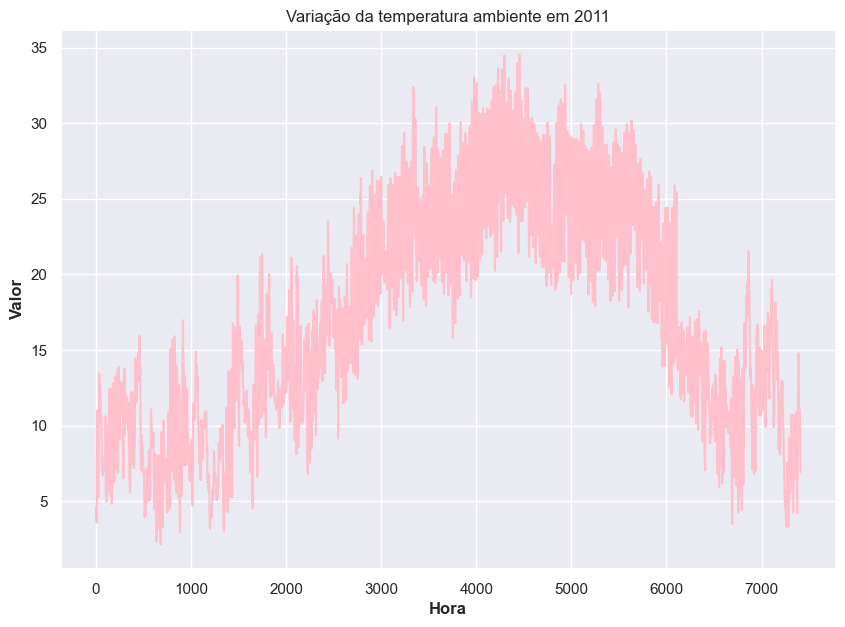

In [32]:
at_2011 = df_2011['AT']
at_2011.plot(xlabel = 'Hora', ylabel = 'Valor', color = 'pink', title = 'Variação da temperatura ambiente em 2011')

Nota-se um certo padrão de temperatura, a qual encontra-se baixa no início das medidas e aumenta no meio do processo, reduzindo no fim do ano. Isso é condizente com a localização da turbina, que entra no verão no meio do ano.

É possível decompor alguma propriedade da série temporal em *tendência*, *sazonalidade* e *ruídos*. **Tendência** refere-se ao comportamento médio dessa propriedade, a qual pode estar crescente, estacionária ou descrescente em um dado período de tempo. **Sazonalidade** indica o padrão de repetição da série temporal, podendo ser *aditiva*, quando a série apresenta flutuações sazonais constantes, ou *multiplicativa*, em que o tamanho das flutuações sazonais varia dependendo do nı́vel global da série [2]. Por fim, os **ruídos** são tudo que não pode ser explicado pelas componentes anteriores, representando dados anômalos ou *outliers*. Quanto menor o ruído melhor o modelo, pois existem menos irregularidades nos dados.

Com o método *seasonal_decompose()* da biblioteca **Statsmodels** [10], calcula-se facilmente as informações explicadas acima, sendo uma ferramenta interessante para a melhor compreensão da sequência temporal. Segue a decomposição para o *CO* pelo modelo aditivo:

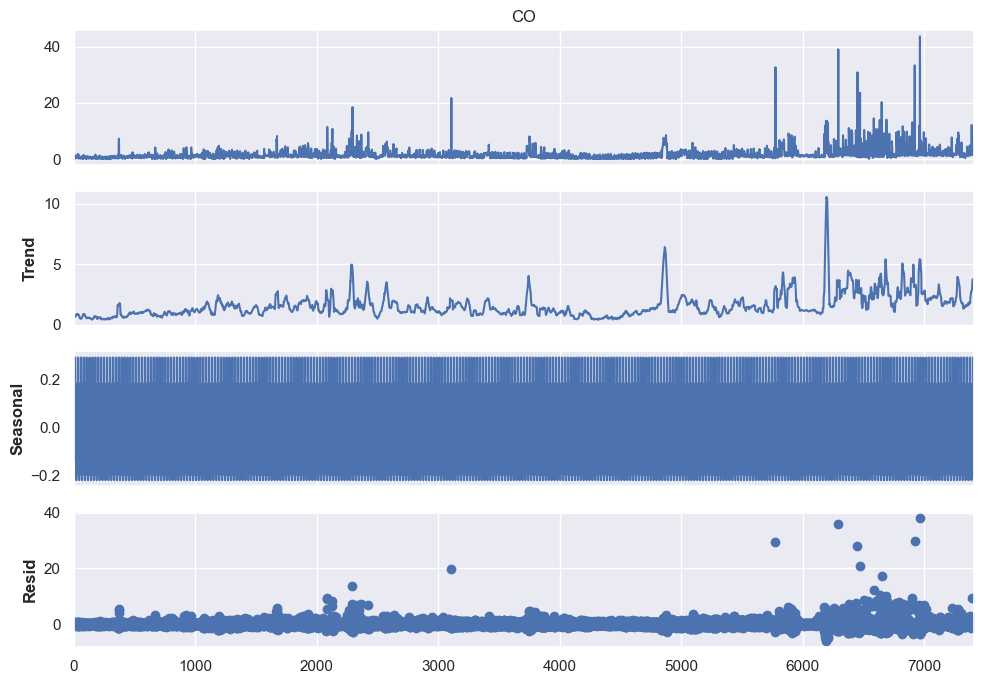

In [53]:
co_2011 = df_2011['CO']

# Definir o período de repetição esperado da série, que deve ser de 1 dia (24 horas)
decomp_add_CO_2011 = seasonal_decompose(co_2011, model='additive', period=24)
decomp_add_CO_2011.plot()

plt.show()

A tendência acompanhou bem a série, no entanto a sazonalidade não está clara por conta da escala de tempo, que é bem maior do que o período de repetição. Os ruídos estão baixos, com poucos outliers encontrados

Fazendo com o modelo multiplicativo:

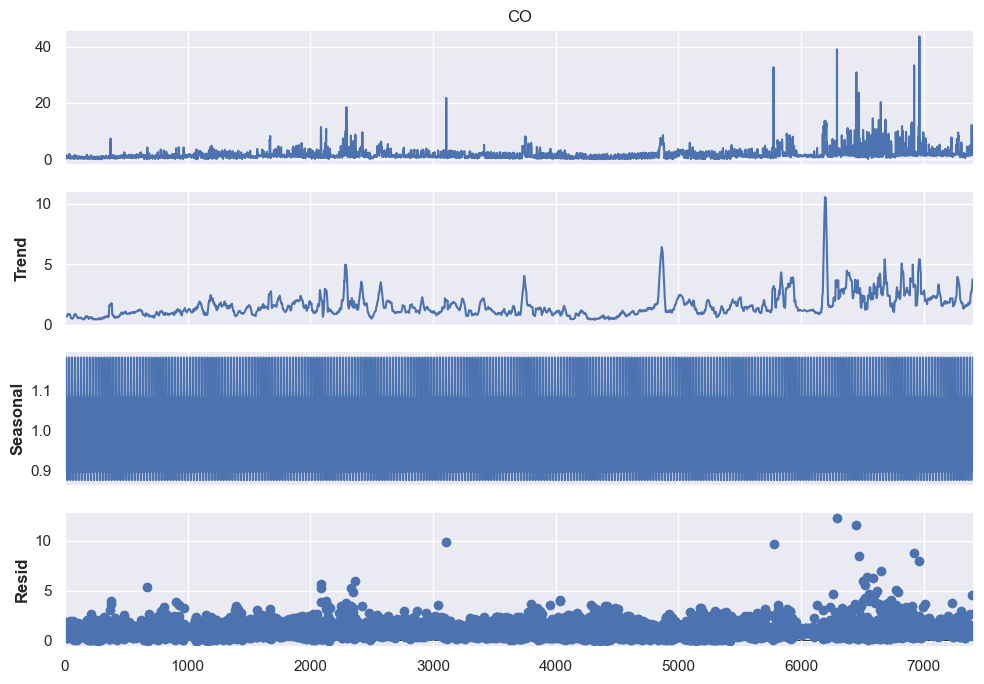

In [58]:
co_2011 = df_2011['CO']

decomp_mul_CO_2011 = seasonal_decompose(co_2011, model='multiplicative', period=24)
decomp_mul_CO_2011.plot()

plt.show()

Perceba que os resíduos ficaram maiores que os do modelo aditivo, indicando que o último pode ser mais adequado para decompor a sequência temporal

Repetindo o procedimento para o NOX e comparando os modelos:

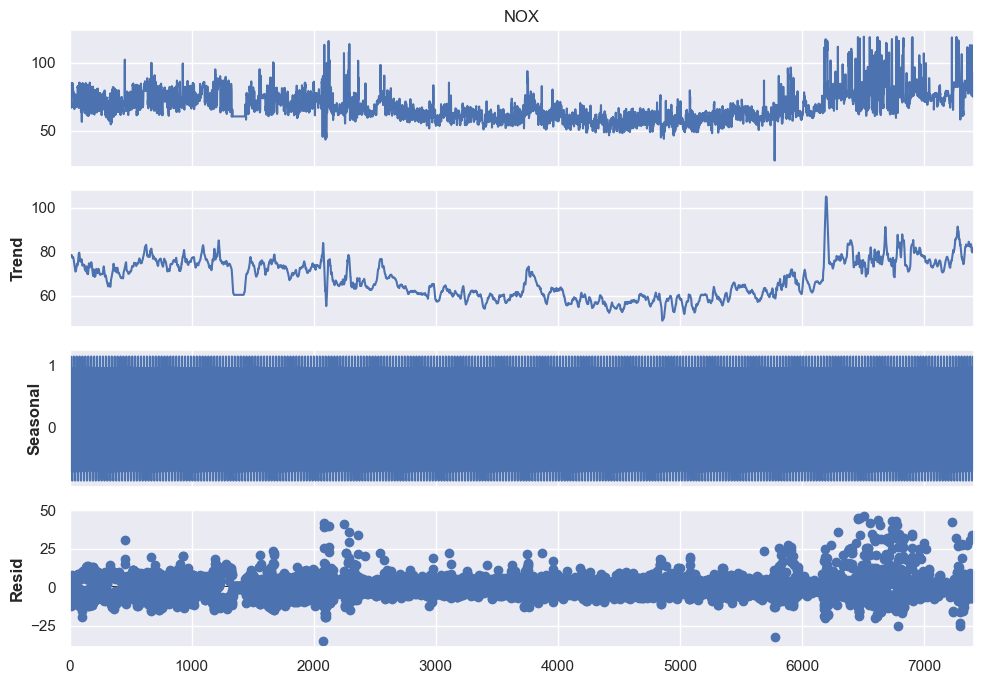

In [55]:
nox_2011 = df_2011['NOX']

decomp_add_NOX_2011 = seasonal_decompose(nox_2011, model='additive', period=24)
decomp_add_NOX_2011.plot()

plt.show()

A sazonalidade permanece com o mesmo comportamento, além de haver outliers negativos

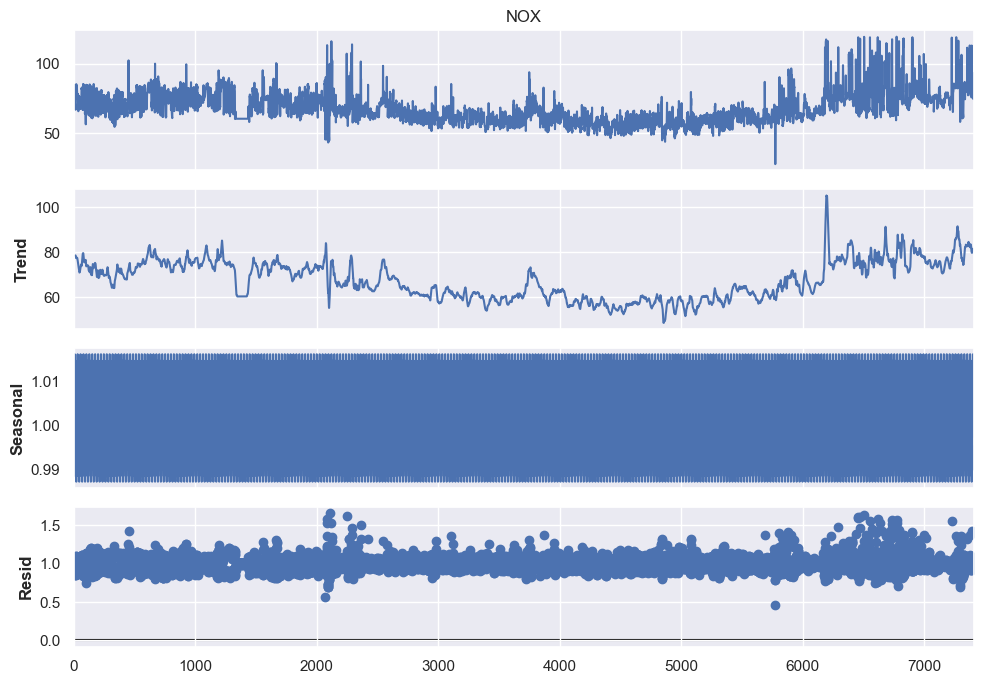

In [56]:
nox_2011 = df_2011['NOX']

decomp_mul_NOX_2011 = seasonal_decompose(nox_2011, model='multiplicative', period=24)
decomp_mul_NOX_2011.plot()

plt.show()

Embora o modelo multiplicativo tenha um ruído com variação menor, o resíduo do modelo aditivo concentra-se em um valor nulo, com média próxima de 0.

#### Dataset 2: 2012

Carregando o dataset:

In [16]:
df_2012

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311
...,...,...,...,...,...,...,...,...,...,...,...
7623,10.0370,1022.1,88.531,2.9192,23.641,1083.6,549.91,132.61,11.745,1.6560,76.068
7624,9.8921,1022.2,87.622,2.9415,23.859,1084.9,550.08,133.57,11.869,1.5549,74.930
7625,9.8723,1022.0,86.618,2.9309,23.817,1084.8,549.99,133.50,11.914,1.4093,75.041
7626,10.0260,1022.0,87.301,2.9363,23.831,1084.5,550.01,133.20,11.811,1.3963,74.460


O número de linhas varia, indicando uma diferença no número de dias operando a turbina e / ou realizando as medições

Visualizando a variação de temperatura para o ano seguinte:

<Axes: >

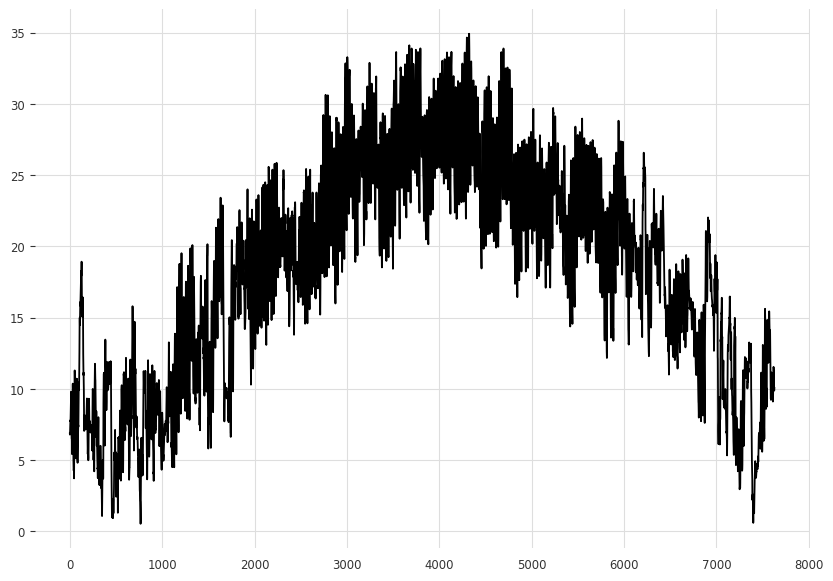

In [18]:
at_2012 = df_2012['AT']
at_2012.plot(xlabel = 'Hora', ylabel = 'Valor', title = 'Variação de temperatura para 2012')

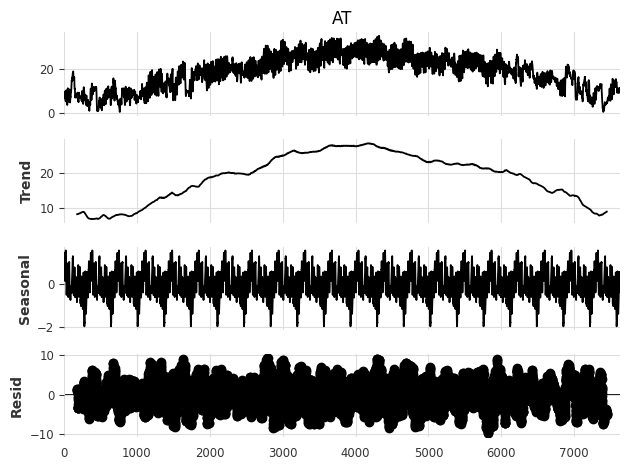

In [19]:
decomp_add_at_2012 = seasonal_decompose(at_2012, model='additive', period=365)
decomp_add_at_2012.plot()

plt.show()

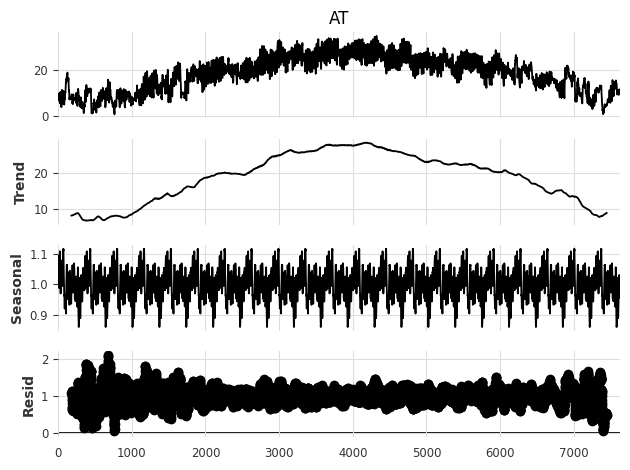

In [20]:
decomp_mul_at_2012 = seasonal_decompose(at_2012, model='multiplicative', period=365)
decomp_mul_at_2012.plot()

plt.show()

#### Dataset 3: 2013

In [21]:
df_2013

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,9.3779,1020.1,90.262,2.3927,19.166,1043.6,541.16,110.16,10.564,9.3472,98.741
1,9.2985,1019.9,89.934,2.3732,19.119,1039.9,538.94,109.23,10.572,11.0160,104.290
2,9.1337,1019.8,89.868,2.3854,19.178,1041.0,539.47,109.62,10.543,10.7500,103.470
3,8.9715,1019.3,89.490,2.3825,19.180,1037.1,536.89,108.88,10.458,12.2870,108.810
4,9.0157,1019.1,89.099,2.4044,19.206,1043.5,541.25,110.09,10.464,9.8229,100.020
...,...,...,...,...,...,...,...,...,...,...,...
7147,4.8631,1027.0,81.084,4.2825,34.045,1100.0,529.98,168.38,14.290,1.2538,78.397
7148,4.5173,1027.4,80.813,4.2481,33.904,1100.1,530.47,168.07,14.344,1.0808,78.251
7149,4.2717,1027.9,80.380,4.2817,34.165,1099.9,529.56,168.55,14.395,1.0472,77.269
7150,4.0853,1028.6,78.907,4.2313,33.802,1100.1,530.61,167.98,14.343,1.0875,77.985


#### Dataset 4: 2014

In [22]:
df_2014

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,8.8358,1022.2,98.762,3.2422,23.152,1067.5,549.94,126.16,11.381,1.9157,68.292
1,9.0529,1021.8,97.464,3.2074,23.207,1067.9,549.80,126.51,11.476,2.0596,68.610
2,9.2464,1021.3,96.494,3.2051,23.296,1068.5,549.89,126.96,11.555,2.1621,68.324
3,9.3792,1020.9,95.912,3.2159,23.465,1069.6,549.94,127.83,11.539,2.1214,67.619
4,9.5757,1020.8,95.412,3.1898,23.205,1068.1,549.83,126.56,11.484,2.1549,66.499
...,...,...,...,...,...,...,...,...,...,...,...
7153,4.6043,1016.7,81.056,2.9386,23.766,1071.6,547.21,131.97,11.645,2.3176,74.015
7154,4.3537,1017.6,80.610,2.7612,21.786,1065.6,550.04,124.65,11.197,5.1828,81.561
7155,4.5199,1018.4,77.402,2.7753,21.921,1066.4,549.91,124.81,11.184,4.9228,82.496
7156,4.2789,1019.3,76.528,2.6798,21.200,1056.6,546.59,119.43,10.953,7.9450,91.232


#### Dataset 5: 2015

In [23]:
df_2015

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515
...,...,...,...,...,...,...,...,...,...,...,...
7379,3.62680,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.9930,89.172
7380,4.16740,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.1440,88.849
7381,5.48200,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.4140,96.147
7382,5.88370,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.3134,64.738


### Conclusão

### Referências

[1] CASSAR, Daniel. **Aprendizado de máquina, k-NN e métricas**. 2024. Material de Aula.

[2] RUSSO, Cibele. **Uma Introdução a Séries Temporais usando o Python**. 2022. Tutorial - Machine Learning School for Materials @Ilum, CNPEM.

[3] Gas Turbine CO and NOx Emission Data Set. 2019. UCI Machine Learning Repository. https://doi.org/10.24432/C5WC95.

[4] Biblioteca *OS*. https://docs.python.org/3/library/os.html

[5] Biblioteca *Numpy*.https://numpy.org/doc/stable/index.html

[6] Biblioteca *Scikit learn*. **Standard Scaler.** https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

[7] Biblioteca *Pandas*. https://pandas.pydata.org/docs/#module-pandas

[8] Biblioteca *OS*. https://matplotlib.org/stable/api/pyplot_summary.html

[9] Biblioteca *Plotly*. **Express.** https://plotly.com/python/plotly-express/

[10] Biblioteca *Statsmodels*. **Seasonal Decompose.** https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

[11] MENOTTI, David. Multiple Layer Perceptron. 2018. Material de aula. https://www.inf.ufpr.br/menotti/ci171-182/slides/ci171-classMLP.pdf

[12] 